In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy

In [2]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [160]:
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

In [398]:
class FEM:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,centre):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = -1e-3   # W/mm^2
        c = 658 #J/kg.K
        rho = 7.6e-6 #kg/mm^3
        kappa = 0.025 #W/mm.K
        ro = 2 #mm
        vo = 2 #mm/s
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        G = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodecoords[:,0] == 0)[0]
        rn = np.where(nodecoords[:,0] == np.max(nodecoords[:,0]))[0]
        bn = np.where(nodecoords[:,1] == 0)[0]
        tn = np.where(nodecoords[:,1] == np.max(nodecoords[:,1]))[0]

        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]
                K[np.ix_(econ,econ)] += kappa*a
                G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X,centre,ro)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T

                for i in range(econ.shape[0]):
                    for j in range(econ.shape[0]):
                        if i!=j and i<j:
                            n1 = econ[i]
                            n2 = econ[j]
                            check_rn = (n1 in rn and n2 in rn)
                            check_tn = (n1 in tn and n2 in tn)
                            check_bn = (n1 in bn and n2 in bn)
                            if check_rn or check_tn or check_bn:
                                line_gp = 3
                                line_ips = np.array(self.data_line["ips"][line_gp])
                                line_weights = np.array(self.data_line["weights"][line_gp])
                                for k,ipk in enumerate(line_ips):
                                    N_line = np.array([(1-ipk)/2, (1+ipk)/2]).reshape(1,-1)
                                    dN_line = np.array([-1/2, 1/2]).reshape(1,-1)
                                    line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #assuming interfacial lines are along x axis
                                    Jac_line = np.matmul(dN_line,line_boundary)
                                    if np.linalg.det(Jac_line)<0:
                                        line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #interchanging nodes"
                                        Jac_line = np.matmul(dN_line,line_boundary)
                                        # if n1 == 0:
                                        #     print(N_line.T[0]*np.linalg.det(Jac_line)*qo*line_weights[k])
                                        # else:
                                        #     print(N_line.T[1]*np.linalg.det(Jac_line)*qo*line_weights[k])
                                    boundary_term[np.ix_([n1,n2],[0])] += N_line.T*np.linalg.det(Jac_line)*qo*line_weights[k]
        # print("K\n",K.round(2))
        # print("G\n",G.round(2))
        # print("F\n",F.round(2))
        # print("B.T\n",boundary_term.round(2))
        return [K,G,F,boundary_term]


In [399]:
soln1 = FEM()

In [400]:
mesh_size_factor = 2

In [401]:
filename = f"rectangle_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
K,G,F,boundary = soln1.fit_ele(nodecoords,ele_con,np.array([[50,25]]))

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932



In [403]:
## left hand side 20 degree dirichlet
T_l = 20
left_nodes = np.where(nodecoords[:,0] == 0)[0]
right_nodes = np.where(nodecoords[:,0] == np.max(nodecoords[:,0]))[0]
bottom_nodes = np.where(nodecoords[:,1] == 0)[0]
top_nodes = np.where(nodecoords[:,1] == np.max(nodecoords[:,1]))[0]

In [419]:
non_left_nodes = np.setdiff1d(np.arange(K.shape[0]),left_nodes)
rhs = F+boundary-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),left_nodes)]+G[np.ix_(np.arange(K.shape[0]),left_nodes)]),axis = 1)
K_sub = K[np.ix_(non_left_nodes,non_left_nodes)]
G_sub = G[np.ix_(non_left_nodes,non_left_nodes)]
rhs_sub = rhs[np.ix_(non_left_nodes,[0])]

In [420]:
theta_sub = np.linalg.inv(K_sub+G_sub)@(rhs_sub)

In [421]:
print(np.sum(boundary))

-0.14999999999999997


In [422]:
np.min(theta_sub)

np.float64(-479.851869710832)

In [423]:
np.max(theta_sub)

np.float64(299.5747683198593)

In [424]:
theta = np.zeros((K.shape[0],1))+T_l
theta[non_left_nodes,:] = theta_sub.reshape(-1,1)

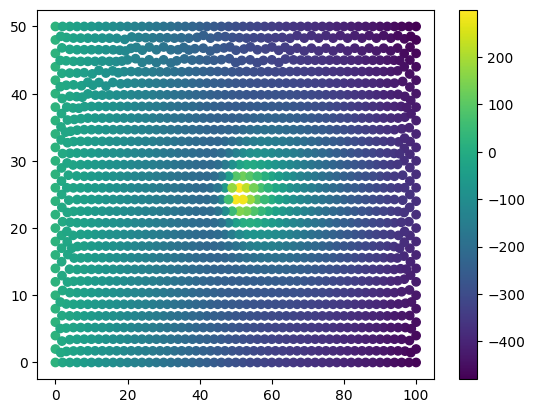

In [425]:
plt.scatter(nodecoords[:,0],nodecoords[:,1],c = theta)
plt.colorbar()
plt.show()